### Exploring Customer Segmentation


<center>
    <img src = images/segments.jpeg>
</center>


In this activity, you are tasked with profiling customer groups for a large telecommunications company.  The data provided contains information on customers purchasing and useage behavior with the telecom products.  Your goal is to use PCA and clustering to segment these customers into meaningful groups, and report back your findings.  

Because these results need to be interpretable, it is important to keep the number of clusters reasonable.  Think about how you might represent some of the non-numeric features so that they can be included in your segmentation models.  You are to report back your approach and findings to the class.  Be specific about what features were used and how you interpret the resulting clusters.

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.linalg import svd
from sklearn.datasets import make_regression
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [101]:
df = pd.read_csv('data/telco_churn_data.csv')

# df.head()
# df.describe()
# df.info()

## Data Cleaning

1. Turn Yes/No columns to 1/0 columns

2. Other columns appear to be important but they also have nonnuneric data. Turn that data into numerical data
   too, with 3 categories getting 0,1,2 , 4 categories getting 0,1,2,3 , etc...

#### Value counts cell
To see what resonses were given and should get converted to numerical

In [ ]:
# Value counts cell to check the various types of responses for each category
df['Churn Category'].value_counts()




### Convert categories to numbers
Numerical data, please.

In [102]:
# Turn all the Yes/No answers to 1/0
df['Referred a Friend'] = df['Referred a Friend'].map({'No': 0, 'Yes': 1})
df['Phone Service'] = df['Phone Service'].map({'Yes': 1, 'No': 0})
df['Multiple Lines'] = df['Multiple Lines'].map({'Yes': 1, 'No': 0})
df['Internet Service'] = df['Internet Service'].map({'Yes': 1, 'No': 0})
df['Online Security'] = df['Online Security'].map({'Yes': 1, 'No': 0})
df['Online Backup'] = df['Online Backup'].map({'Yes': 1, 'No': 0})
df['Device Protection Plan'] = df['Device Protection Plan'].map({'Yes': 1, 'No': 0})
df['Premium Tech Support'] = df['Premium Tech Support'].map({'Yes': 1, 'No': 0})
df['Streaming TV'] = df['Streaming TV'].map({'Yes': 1, 'No': 0})
df['Streaming Movies'] = df['Streaming Movies'].map({'Yes': 1, 'No': 0})
df['Streaming Music'] = df['Streaming Music'].map({'Yes': 1, 'No': 0})
df['Unlimited Data'] = df['Unlimited Data'].map({'Yes': 1, 'No': 0})
df['Paperless Billing'] = df['Paperless Billing'].map({'Yes': 1, 'No': 0})
df['Under 30'] = df['Under 30'].map({'Yes': 1, 'No': 0})
df['Senior Citizen'] = df['Senior Citizen'].map({'Yes': 1, 'No': 0})
df['Married'] = df['Married'].map({'Yes': 1, 'No': 0})
df['Dependents'] = df['Dependents'].map({'Yes': 1, 'No': 0})

# Change columns with string options to numbers
df['Offer'] = df['Offer'].map({'None': 0, 'Offer A': 1, 'Offer B': 2, 'Offer C': 3, 'Offer D': 4, 'Offer E': 5})

df['Internet Type'] = df['Internet Type'].map({'None':0, 'Fiber Optic':1, 'DSL':2, 'Cable':3})

df['Contract'] = df['Contract'].map({'Month-to-Month':0, 'One Year':1, 'Two Year':2})

df['Payment Method'] = df['Payment Method'].map({'Bank Withdrawal':0, 'Credit Card':1, 'Mailed Check':2})

df['Gender'] = df['Gender'].map({'Male':0, 'Female':1})

#For some reason, the 'Offer' category has NaNs instead of 0s. This fixes that
df.fillna(0, inplace=True, downcast='infer')

# df.to_csv('data/df2.csv')
df.head(30)


C:\Users\sspillane\AppData\Local\Temp\ipykernel_38592\4126993732.py:32: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df.fillna(0, inplace=True, downcast='infer')


,Customer ID,Referred a Friend,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Internet Type,...,Latitude,Longitude,Population,Churn Value,CLTV,Churn Type,Churn Reason,Total Customer Svc Requests,Product/Service Issues Reported,Customer Satisfaction
0,8779-QRDMV,0,0,1,0,0,0.00,0,1,1,...,34.023810,-118.156582,68701,1,5433,Competitor,Competitor offered more data,5,0,0
1,7495-OOKFY,1,1,8,5,1,48.85,1,1,3,...,34.044271,-118.185237,55668,1,5302,Competitor,Competitor made better offer,5,0,0
2,1658-BYGOY,0,0,18,4,1,11.33,1,1,1,...,34.108833,-118.229715,47534,1,3179,Competitor,Competitor made better offer,1,0,0
3,4598-XLKNJ,1,1,25,3,1,19.76,0,1,1,...,33.936291,-118.332639,27778,1,5337,Dissatisfaction,Limited range of services,1,1,2
4,4846-WHAFZ,1,1,37,3,1,6.33,1,1,3,...,33.972119,-118.020188,26265,1,2793,Price,Extra data charges,1,0,2
5,4412-YLTKF,0,0,27,3,1,3.33,1,1,1,...,33.989524,-118.089299,63288,1,4638,Competitor,Competitor had better devices,0,0,0
6,0390-DCFDQ,1,1,1,5,1,15.28,0,1,3,...,33.794990,-118.065591,21343,1,3964,Other,Don't know,7,0,0
7,3445-HXXGF,1,6,58,2,0,0.00,0,1,3,...,34.168686,-118.057505,10558,1,5444,Dissatisfaction,Service dissatisfaction,2,1,1
8,2656-FMOKZ,0,0,15,4,1,44.07,1,1,3,...,34.139402,-118.128658,23742,1,5717,Dissatisfaction,Limited range of services,3,0,2
9,2070-FNEXE,0,0,7,5,1,26.95,0,1,2,...,34.159007,-118.087353,32369,1,4419,Price,Lack of affordable download/upload speed,3,0,0


## Drop non-numeric columns
Bye!

In [103]:
object_cols = df.select_dtypes('object').columns.tolist()
df_numeric = df.drop(object_cols,axis=1)

In [104]:
df_numeric.head(30)
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 42 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Referred a Friend                  7043 non-null   int64  
 1   Number of Referrals                7043 non-null   int64  
 2   Tenure in Months                   7043 non-null   int64  
 3   Offer                              7043 non-null   int64  
 4   Phone Service                      7043 non-null   int64  
 5   Avg Monthly Long Distance Charges  7043 non-null   float64
 6   Multiple Lines                     7043 non-null   int64  
 7   Internet Service                   7043 non-null   int64  
 8   Internet Type                      7043 non-null   int64  
 9   Avg Monthly GB Download            7043 non-null   int64  
 10  Online Security                    7043 non-null   int64  
 11  Online Backup                      7043 non-null   int64

## Scale the data and apply Singluar Value Decomposition
Using a function from Coding Activity 6.3

In [106]:
scaler = StandardScaler()
df_scaled = (df_numeric - df_numeric.mean())/df_numeric.std()




([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41],
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23'),
  Text(24, 0, '24'),
  Text(25, 0, '25'),
  Text(26, 0, '26'),
  Text(27, 0, '27'),
  Text(28, 0, '28'),
  Text(29, 0, '29'),
  Text(30, 0, '30'),
  Text(31, 0, '31'),
  Text(32, 0, '32'),
  Text(33, 0, '33'),
  Text(34, 0, '34'),
  Text(35, 0, '35'),
  Text(36, 0, '36'),


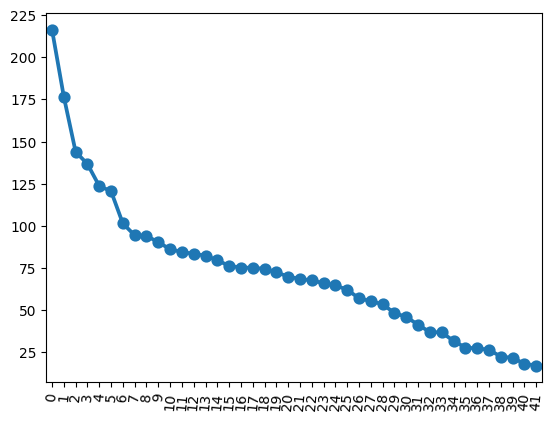

In [127]:
U, sigma, VT = svd(df_scaled)

sns.pointplot(data=sigma)
plt.xticks(rotation=85)


[0, 1, 3, 5, 9, 12, 16, 20, 25, 31, 41]


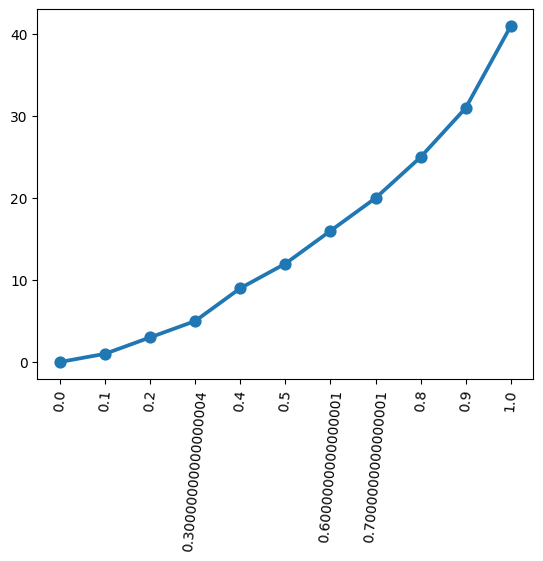

In [128]:
variance_plot_by_primary_component =[]
percent_variance_explained = sigma/sigma.sum()
percent_variance = np.linspace(0,1,11, endpoint=True)
for n in percent_variance:
    category_number = int( (np.cumsum(percent_variance_explained) < n).sum() )
    variance_plot_by_primary_component.append(category_number)


sns.pointplot(x=percent_variance, y=variance_plot_by_primary_component)
plt.xticks(rotation=85)

print(variance_plot_by_primary_component)

## Now, we have a decision on how many components to use

To get over 80% of the variance we would need to include over 20 components, but from the graph it appears
that the top 8 components carry a heavier weight than the rest, which only add up because there are so many of them

I will try clustering with 8 components and 21 components to see what differences arise

In [ ]:
pca = PCA(n_components=3, random_state = 42)
components = pca.fit_transform(df_scaled)

In [ ]:
# Since the Churn Category and Churn Reason are both present for 1870/7044 rows,
# let's treat that dataset separately and see what happens there, in addition to
# the whole set with only those categories dropped

